In [1]:
import pandas as pd
from konlpy.tag import Okt
from konlpy.tag import Kkma
from gensim import models
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import KeyedVectors

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, Bidirectional, Dropout, Flatten, SimpleRNN, BatchNormalization
from tensorflow.keras import regularizers

In [2]:
file = '/Users/um_seun/project6/한국어_단발성_대화_데이터셋.xlsx'

df = pd.read_excel(file)


In [3]:
df.head(5)

,Sentence,Emotion,Unnamed: 2,Unnamed: 3,Unnamed: 4,공포,5468
0,언니 동생으로 부르는게 맞는 일인가요..??,공포,NaN,NaN,NaN,놀람,5898.0
1,그냥 내 느낌일뿐겠지?,공포,NaN,NaN,NaN,분노,5665.0
2,아직너무초기라서 그런거죠?,공포,NaN,NaN,NaN,슬픔,5267.0
3,유치원버스 사고 낫다던데,공포,NaN,NaN,NaN,중립,4830.0
4,근데 원래이런거맞나요,공포,NaN,NaN,NaN,행복,6037.0


In [4]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38594 entries, 0 to 38593
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sentence    38594 non-null  object 
 1   Emotion     38594 non-null  object 
 2   Unnamed: 2  0 non-null      float64
 3   Unnamed: 3  0 non-null      float64
 4   Unnamed: 4  0 non-null      float64
 5   공포          7 non-null      object 
 6   5468        7 non-null      float64
dtypes: float64(4), object(3)
memory usage: 2.1+ MB
None


In [5]:
print(df['Emotion'].value_counts(normalize=True))


행복    0.156423
놀람    0.152822
분노    0.146784
공포    0.141680
혐오    0.140670
슬픔    0.136472
중립    0.125149
Name: Emotion, dtype: float64


In [6]:
df = df[['Sentence','Emotion']]


df.dropna(axis=0,inplace = True)


print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38594 entries, 0 to 38593
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  38594 non-null  object
 1   Emotion   38594 non-null  object
dtypes: object(2)
memory usage: 603.2+ KB
None


In [7]:
print(df['Emotion'].unique())    


['공포' '놀람' '분노' '슬픔' '중립' '행복' '혐오']


In [8]:
def lav(x):
    if x == '공포':
        return int(0)
    if x == '놀람':
        return int(1)
    if x == '분노':
        return int(2)
    if x == '슬픔':
        return int(3)
    if x == '중립':
        return int(4)
    if x == '행복':
        return int(5)
    if x == '혐오':
        return int(6)



df['Emotion'] = df['Emotion'].apply(lav)


In [9]:
print(df['Emotion'].unique())

[0 1 2 3 4 5 6]


In [10]:
import re

def emoticon_del(data):
    #이모티콘 제거
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    #분석에 어긋나는 불용어구 제외 (특수문자, 의성어)
    han = re.compile(r'[ㄱ-ㅎㅏ-ㅣ!?~,"a-zA-z0-9:.\n\r#\ufeff\u200d]')

    comment_list = []
    for i in range(len(data)):
        comment_list.append(data['Sentence'].iloc[i])

    comment_result = []
    for i in comment_list:
        tokens = re.sub(emoji_pattern,"",str(i))
        tokens = re.sub(han,"",tokens)
        comment_result.append(tokens)
    comment_result = pd.DataFrame(comment_result, columns=["Sentence"])
    data['Sentence'] = comment_result 

    return data

In [11]:
data = emoticon_del(df)

In [12]:
data

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요,0
1,그냥 내 느낌일뿐겠지,0
2,아직너무초기라서 그런거죠,0
3,유치원버스 사고 낫다던데,0
4,근데 원래이런거맞나요,0
...,...,...
38589,솔직히 예보 제대로 못하는 데 세금이라도 아끼게 그냥 폐지해라,6
38590,재미가 없으니 망하지,6
38591,공장 도시락 비우생적임 아르바이트했는데 화장실가성 손도 않씯고 재료 담고 바닥 떨어...,6
38592,코딱지 만한 나라에서 지들끼리 피터지게 싸우는 센징 클래스,6


In [13]:
from konlpy.tag import Mecab
from konlpy.tag import Okt
def tokenizer(data):
    # 불용어(포함 안 시킬 단어) 처리 
    stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '되', '음', '면','있','거','나','는데','!', '.', ',', '~', '?', 'ㅡ', 'ㅠ', 'ㅜ','/', ' '] 
           
    mecab = Mecab()
    
    data['tokenized'] = data['Sentence'].apply(mecab.morphs)
    data['tokenized'] = data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
    
    


In [14]:
tokenizer(data)

In [15]:
data

,Sentence,Emotion,tokenized
0,언니 동생으로 부르는게 맞는 일인가요,0,"[언니, 동생, 으로, 부르, 맞, 일, 인가요]"
1,그냥 내 느낌일뿐겠지,0,"[그냥, 내, 느낌, 일, 뿐, 겠]"
2,아직너무초기라서 그런거죠,0,"[아직, 너무, 초기, 라서, 그런, 죠]"
3,유치원버스 사고 낫다던데,0,"[유치원, 버스, 사고, 낫, 다던데]"
4,근데 원래이런거맞나요,0,"[근데, 원래, 이런, 맞, 나요]"
...,...,...,...
38589,솔직히 예보 제대로 못하는 데 세금이라도 아끼게 그냥 폐지해라,6,"[솔직히, 예보, 제대로, 못, 데, 세금, 라도, 아끼, 그냥, 폐지, 해라]"
38590,재미가 없으니 망하지,6,"[재미, 없, 으니, 망하]"
38591,공장 도시락 비우생적임 아르바이트했는데 화장실가성 손도 않씯고 재료 담고 바닥 떨어...,6,"[공장, 도시락, 비, 우생, 적, 아르바이트, 했, 화장실, 가성, 손, 않, 씯..."
38592,코딱지 만한 나라에서 지들끼리 피터지게 싸우는 센징 클래스,6,"[코딱지, 나라, 에서, 끼리, 피, 터지, 싸우, 센, 징, 클래스]"


In [16]:
#def more_than_one(comment):
#    comment = [n for n in comment if len(n) > 1]       #단어 길이 1 이하 제거
#    return comment
#data['tokenized2'] = data['tokenized'].apply(more_than_one)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
x_train, x_test = train_test_split(data[['tokenized','Emotion']], test_size=0.20, stratify=data['Emotion'], random_state=33)

In [19]:
# 각 감정별 많이 등장한 단어
fear_words = np.hstack(data[data.Emotion == 0]['tokenized'].values)
Surprised_words = np.hstack(data[data.Emotion == 1]['tokenized'].values)
Anger_words = np.hstack(data[data.Emotion == 2]['tokenized'].values)
Sadness_words = np.hstack(data[data.Emotion == 3]['tokenized'].values)
neutrality_words = np.hstack(data[data.Emotion == 4]['tokenized'].values)
Happiness_words = np.hstack(data[data.Emotion == 5]['tokenized'].values)
Disgust_words = np.hstack(data[data.Emotion == 6]['tokenized'].values)

In [20]:
def counters(words): 
    emotion_words = Counter(words)
    print('TOP_10',emotion_words.most_common(10))

In [21]:
counters(fear_words)
counters(Surprised_words)
counters(Anger_words)
counters(Sadness_words)
counters(neutrality_words)
counters(Happiness_words)
counters(Disgust_words)

TOP_10 [('안', 490), ('겠', 392), ('네요', 347), ('같', 326), ('없', 294), ('보', 287), ('해야', 284), ('아', 260), ('어', 255), ('어떻게', 251)]
TOP_10 [('보', 312), ('진짜', 301), ('안', 297), ('아니', 271), ('냐', 269), ('어', 269), ('에서', 249), ('왜', 242), ('했', 240), ('었', 239)]
TOP_10 [('냐', 492), ('아', 431), ('안', 373), ('라', 339), ('없', 320), ('으로', 296), ('나라', 288), ('로', 288), ('어', 279), ('말', 270)]
TOP_10 [('네요', 568), ('안', 517), ('너무', 448), ('없', 403), ('겠', 351), ('보', 334), ('아', 323), ('어', 299), ('같', 297), ('어요', 278)]
TOP_10 [('안', 321), ('겠', 281), ('없', 277), ('보', 240), ('으로', 238), ('로', 226), ('에서', 214), ('것', 210), ('같', 209), ('할', 188)]
TOP_10 [('좋', 557), ('감사', 520), ('합니다', 507), ('잘', 431), ('보', 427), ('주', 402), ('님', 391), ('습니다', 379), ('해', 363), ('네요', 358)]
TOP_10 [('안', 460), ('없', 397), ('아', 391), ('냐', 378), ('어', 322), ('겠', 304), ('말', 298), ('니', 289), ('으로', 271), ('로', 271)]


In [22]:

fear_words_len  = data[data.Emotion == 0]['tokenized'].map(lambda x: len(x))
Surprised_words_len  = data[data.Emotion == 1]['tokenized'].map(lambda x: len(x))
Anger_words_len  = data[data.Emotion == 2]['tokenized'].map(lambda x: len(x))
Sadness_words_len  = data[data.Emotion == 3]['tokenized'].map(lambda x: len(x))
neutrality_words_len  = data[data.Emotion == 4]['tokenized'].map(lambda x: len(x))
Happiness_words_len  = data[data.Emotion == 5]['tokenized'].map(lambda x: len(x))
Disgust_words_len  = data[data.Emotion == 6]['tokenized'].map(lambda x: len(x))


In [23]:
print('공포리뷰 평균 길이', np.mean(fear_words_len))
print('놀람리뷰 평균 길이', np.mean(Surprised_words_len))
print('분노리뷰 평균 길이', np.mean(Anger_words_len))
print('슬픔리뷰 평균 길이', np.mean(Sadness_words_len))
print('중립리뷰 평균 길이', np.mean(neutrality_words_len))
print('행복리뷰 평균 길이', np.mean(Happiness_words_len))
print('혐오리뷰 평균 길이', np.mean(Disgust_words_len))

공포리뷰 평균 길이 7.7873079736649595
놀람리뷰 평균 길이 6.770261105459478
분노리뷰 평균 길이 8.286142983230361
슬픔리뷰 평균 길이 7.827226124928802
중립리뷰 평균 길이 7.8648033126294
행복리뷰 평균 길이 7.430511843630942
혐오리뷰 평균 길이 9.114754098360656


In [24]:
data['length'] = data['tokenized'].apply(lambda x: len(x))

/Users/um_seun/miniforge3/envs/cp1/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


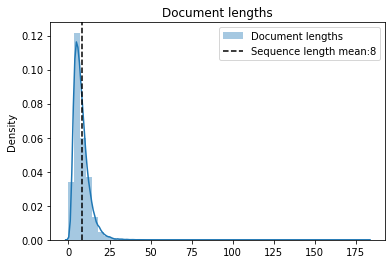

 가장 긴 문장은 182 개의 단어, 가장 짧은 문장은 0 개의 단어


In [25]:


def plot_doc_lengths(datas):
    mean_seq_len = np.round(datas.length.mean()).astype(int)
    sns.distplot(tuple(datas.length), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {data['length'].max()} 개의 단어, 가장 짧은 문장은 {data['length'].min()} 개의 단어")

plot_doc_lengths(data)

In [26]:
x_train_tokenized = x_train['tokenized']
x_test_tokenized = x_test['tokenized']
y_train = x_train['Emotion']
y_test = x_test['Emotion']


In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [28]:
token = Tokenizer(oov_token='<oov>')  #oov문제 발생시 대체 단어
token.fit_on_texts(x_train_tokenized)             # 토큰화

word_index = token.word_index           # 인덱스 별 단어

print('총단어 갯수',len(word_index))
word_index

총단어 갯수 22764


{'<oov>': 1,
 '안': 2,
 '아': 3,
 '보': 4,
 '없': 5,
 '어': 6,
 '겠': 7,
 '같': 8,
 '으로': 9,
 '네요': 10,
 '로': 11,
 '것': 12,
 '해': 13,
 '에서': 14,
 '냐': 15,
 '말': 16,
 '진짜': 17,
 '좋': 18,
 '했': 19,
 '너무': 20,
 '주': 21,
 '기': 22,
 '할': 23,
 '잘': 24,
 '사람': 25,
 '아니': 26,
 '었': 27,
 '라': 28,
 '일': 29,
 '니': 30,
 '야': 31,
 '저': 32,
 '나라': 33,
 '못': 34,
 '수': 35,
 '왜': 36,
 '서': 37,
 '때': 38,
 '않': 39,
 '더': 40,
 '알': 41,
 '정말': 42,
 '받': 43,
 '내': 44,
 '어요': 45,
 '그': 46,
 '년': 47,
 '좀': 48,
 '시': 49,
 '뭐': 50,
 '합니다': 51,
 '싶': 52,
 '님': 53,
 '우리': 54,
 '았': 55,
 '습니다': 56,
 '까지': 57,
 '적': 58,
 '라고': 59,
 '먹': 60,
 '해서': 61,
 '생각': 62,
 '제': 63,
 '돈': 64,
 '이런': 65,
 '많': 66,
 '자': 67,
 '살': 68,
 '해야': 69,
 '인데': 70,
 '국민': 71,
 '지만': 72,
 '으면': 73,
 '지금': 74,
 '다고': 75,
 '건': 76,
 '개': 77,
 '요': 78,
 '어떻게': 79,
 '그냥': 80,
 '많이': 81,
 '죠': 82,
 '줄': 83,
 '나요': 84,
 '여자': 85,
 '한테': 86,
 '감사': 87,
 '이제': 88,
 '던': 89,
 '전': 90,
 '어서': 91,
 '데': 92,
 '오': 93,
 '부터': 94,
 '사': 95,
 '남자': 96,
 '보다':

In [29]:
x_train_tokenized = token.texts_to_sequences(x_train_tokenized)     # 시퀸스 형태로 변환 ( 각 단어의 인덱스 )
x_test_tokenized = token.texts_to_sequences(x_test_tokenized)

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 25    # 문장 최대길이 위 시각화 보고 판단

x_train_pad = pad_sequences(x_train_tokenized, maxlen=max_len, padding='post')   # 패딩처리 ( 문장 길이 맞춤 )
x_test_pad = pad_sequences(x_test_tokenized, maxlen=max_len, padding='post')

In [31]:
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(df['사람문장1'], df['감정_대분류'], test_size=0.25, random_state=2)

In [32]:
print(x_train_pad[0])
x_train_pad.shape, x_test_pad.shape


[  32 4128 2167  198  283    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


((30875, 25), (7719, 25))

# 단층 RNN

In [33]:
vocab_size = len(word_index) + 1  #토큰단어총갯수 단어갯수 0부터니 1더해서,
dim = 100 #줄일 단어 임베딩 차원?
max_length = 25   #입력 문장길이

In [34]:
model_1 = Sequential()
model_1.add(Embedding(vocab_size, dim, mask_zero=True, input_length=max_length)) # mask_zero=True (패딩처리 인덱스0에 대해 의미 부여 하지않음)
model_1.add(SimpleRNN(128))
model_1.add(Dense(7, activation='softmax'))

Metal device set to: Apple M1 Pro


2022-07-06 13:40:43.166249: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-06 13:40:43.166386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [35]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           2276500   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 2,306,715
Trainable params: 2,306,715
Non-trainable params: 0
_________________________________________________________________


In [36]:
model_1.compile(loss='sparse_categorical_crossentropy',#'sparse_categorical_crossentropy'
             optimizer='adam',
             metrics=['accuracy'])

In [37]:
history_1 = model_1.fit(x_train_pad, y_train, 
        epochs=8,
        batch_size=256,
        validation_data=(x_test_pad, y_test))

Epoch 1/8


2022-07-06 13:40:43.317077: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-06 13:40:43.773962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 [==============================] - ETA: 0s - loss: 1.6880 - accuracy: 0.3402

2022-07-06 13:41:40.839115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 [==============================] - 59s 483ms/step - loss: 1.6880 - accuracy: 0.3402 - val_loss: 1.4554 - val_accuracy: 0.4306
Epoch 2/8
121/121 [==============================] - 53s 439ms/step - loss: 1.1266 - accuracy: 0.5966 - val_loss: 1.4681 - val_accuracy: 0.4406
Epoch 3/8
121/121 [==============================] - 58s 482ms/step - loss: 0.6027 - accuracy: 0.8051 - val_loss: 1.7433 - val_accuracy: 0.4376
Epoch 4/8
121/121 [==============================] - 59s 487ms/step - loss: 0.2804 - accuracy: 0.9163 - val_loss: 2.1949 - val_accuracy: 0.4125
Epoch 5/8
121/121 [==============================] - 58s 476ms/step - loss: 0.1576 - accuracy: 0.9544 - val_loss: 2.4858 - val_accuracy: 0.4073
Epoch 6/8
121/121 [==============================] - 59s 487ms/step - loss: 0.0981 - accuracy: 0.9733 - val_loss: 2.7630 - val_accuracy: 0.3989
Epoch 7/8
121/121 [==============================] - 61s 507ms/step - loss: 0.0659 - accuracy: 0.9831 - val_loss: 3.0294 - val_accuracy: 0.3976
Ep

# 다층 RNN

In [38]:
model_2 = Sequential()
model_2.add(Embedding(vocab_size, dim, mask_zero=True, input_length=max_length)) # mask_zero=True (패딩처리 인덱스0에 대해 의미 부여 하지않음)
model_2.add(SimpleRNN(128, return_sequences=True))
model_2.add(SimpleRNN(128, return_sequences=False))
model_2.add(Dense(7, activation='softmax'))

In [39]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 100)           2276500   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 25, 128)           29312     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 2,339,611
Trainable params: 2,339,611
Non-trainable params: 0
_________________________________________________________________


In [40]:
model_2.compile(loss='sparse_categorical_crossentropy',#'sparse_categorical_crossentropy'
             optimizer='adam',
             metrics=['accuracy'])

In [41]:
history_2 = model_2.fit(x_train_pad, y_train, 
        epochs=8,
        batch_size=256,
        validation_data=(x_test_pad, y_test))

Epoch 1/8


2022-07-06 13:48:33.133241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 [==============================] - ETA: 0s - loss: 1.6641 - accuracy: 0.3369

2022-07-06 13:50:32.876258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 [==============================] - 124s 1s/step - loss: 1.6641 - accuracy: 0.3369 - val_loss: 1.4521 - val_accuracy: 0.4345
Epoch 2/8
121/121 [==============================] - 121s 1s/step - loss: 1.0672 - accuracy: 0.6109 - val_loss: 1.5441 - val_accuracy: 0.4291
Epoch 3/8
121/121 [==============================] - 114s 939ms/step - loss: 0.5176 - accuracy: 0.8284 - val_loss: 1.9382 - val_accuracy: 0.4229
Epoch 4/8
121/121 [==============================] - 116s 960ms/step - loss: 0.2353 - accuracy: 0.9256 - val_loss: 2.3935 - val_accuracy: 0.4012
Epoch 5/8
121/121 [==============================] - 115s 949ms/step - loss: 0.1258 - accuracy: 0.9624 - val_loss: 2.8301 - val_accuracy: 0.3958
Epoch 6/8
121/121 [==============================] - 122s 1s/step - loss: 0.0789 - accuracy: 0.9766 - val_loss: 3.1524 - val_accuracy: 0.3980
Epoch 7/8
121/121 [==============================] - 122s 1s/step - loss: 0.0547 - accuracy: 0.9846 - val_loss: 3.4285 - val_accuracy: 0.3906
Epoch 8

# 단층 LSTM

In [42]:
model_3 = Sequential()
model_3.add(Embedding(vocab_size, dim, mask_zero=True, input_length=max_length)) # mask_zero=True (패딩처리 인덱스0에 대해 의미 부여 하지않음)
model_3.add(LSTM(128))
model_3.add(Dense(7, activation='softmax'))

In [43]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 100)           2276500   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 7)                 903       
                                                                 
Total params: 2,394,651
Trainable params: 2,394,651
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_3.compile(loss='sparse_categorical_crossentropy',#'sparse_categorical_crossentropy'
             optimizer='adam',
             metrics=['accuracy'])

In [45]:
history_3 = model_3.fit(x_train_pad, y_train, 
        epochs=8,
        batch_size=256,
        validation_data=(x_test_pad, y_test))

Epoch 1/8


2022-07-06 14:04:34.528814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:04:34.767019: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_19'
2022-07-06 14:04:34.770406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:04:35.006134: I tens

121/121 [==============================] - ETA: 0s - loss: 1.8257 - accuracy: 0.2305

2022-07-06 14:04:45.158008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:04:45.297252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 [==============================] - 13s 89ms/step - loss: 1.8257 - accuracy: 0.2305 - val_loss: 1.6660 - val_accuracy: 0.3091
Epoch 2/8
121/121 [==============================] - 9s 76ms/step - loss: 1.5028 - accuracy: 0.3806 - val_loss: 1.4990 - val_accuracy: 0.3955
Epoch 3/8
121/121 [==============================] - 9s 75ms/step - loss: 1.2411 - accuracy: 0.5069 - val_loss: 1.4889 - val_accuracy: 0.4243
Epoch 4/8
121/121 [==============================] - 9s 68ms/step - loss: 1.0498 - accuracy: 0.5932 - val_loss: 1.5752 - val_accuracy: 0.4186
Epoch 5/8
121/121 [==============================] - 9s 73ms/step - loss: 0.9193 - accuracy: 0.6531 - val_loss: 1.6732 - val_accuracy: 0.4139
Epoch 6/8
121/121 [==============================] - 9s 75ms/step - loss: 0.8227 - accuracy: 0.6968 - val_loss: 1.8270 - val_accuracy: 0.4166
Epoch 7/8
121/121 [==============================] - 9s 71ms/step - loss: 0.7377 - accuracy: 0.7388 - val_loss: 1.8832 - val_accuracy: 0.4131
Epoch 8/8
121/1

# 다층 LSTM

In [46]:
model_4 = Sequential()
model_4.add(Embedding(vocab_size, dim, mask_zero=True, input_length=max_length)) # mask_zero=True (패딩처리 인덱스0에 대해 의미 부여 하지않음)
model_4.add(LSTM(128, return_sequences=True))
model_4.add(LSTM(128, return_sequences=False))
model_4.add(Dense(7, activation='softmax'))

In [47]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 25, 100)           2276500   
                                                                 
 lstm_1 (LSTM)               (None, 25, 128)           117248    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 7)                 903       
                                                                 
Total params: 2,526,235
Trainable params: 2,526,235
Non-trainable params: 0
_________________________________________________________________


In [48]:
model_4.compile(loss='sparse_categorical_crossentropy',#'sparse_categorical_crossentropy'
             optimizer='adam',
             metrics=['accuracy'])

In [49]:
history_4 = model_4.fit(x_train_pad, y_train, 
        epochs=8,
        batch_size=256,
        validation_data=(x_test_pad, y_test))

Epoch 1/8


2022-07-06 14:05:52.282147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:05:52.738192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:05:52.926454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:05:53.141881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:05:53.382940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 [==============================] - ETA: 0s - loss: 1.7389 - accuracy: 0.2716

2022-07-06 14:06:09.416203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:06:09.669929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:06:09.779021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 [==============================] - 22s 144ms/step - loss: 1.7389 - accuracy: 0.2716 - val_loss: 1.5535 - val_accuracy: 0.3607
Epoch 2/8
121/121 [==============================] - 14s 114ms/step - loss: 1.3936 - accuracy: 0.4351 - val_loss: 1.4799 - val_accuracy: 0.4118
Epoch 3/8
121/121 [==============================] - 14s 116ms/step - loss: 1.1878 - accuracy: 0.5326 - val_loss: 1.4857 - val_accuracy: 0.4289
Epoch 4/8
121/121 [==============================] - 14s 114ms/step - loss: 1.0106 - accuracy: 0.6140 - val_loss: 1.5661 - val_accuracy: 0.4214
Epoch 5/8
121/121 [==============================] - 12s 99ms/step - loss: 0.8821 - accuracy: 0.6783 - val_loss: 1.6591 - val_accuracy: 0.4161
Epoch 6/8
121/121 [==============================] - 14s 114ms/step - loss: 0.7799 - accuracy: 0.7269 - val_loss: 1.8553 - val_accuracy: 0.4183
Epoch 7/8
121/121 [==============================] - 14s 113ms/step - loss: 0.6896 - accuracy: 0.7655 - val_loss: 1.9186 - val_accuracy: 0.4222
Epo

# 단층 Bi LSTM

In [50]:
model_5 = Sequential()
model_5.add(Embedding(vocab_size, dim, mask_zero=True, input_length=max_length)) # mask_zero=True (패딩처리 인덱스0에 대해 의미 부여 하지않음)
model_5.add(Bidirectional(LSTM(128)))
model_5.add(Dense(7, activation='softmax'))

In [51]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 25, 100)           2276500   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 2,512,795
Trainable params: 2,512,795
Non-trainable params: 0
_________________________________________________________________


In [52]:
model_5.compile(loss='sparse_categorical_crossentropy',#'sparse_categorical_crossentropy'
             optimizer='adam',
             metrics=['accuracy'])

In [53]:
history_5 = model_5.fit(x_train_pad, y_train, 
        epochs=8,
        batch_size=256,
        validation_data=(x_test_pad, y_test))

Epoch 1/8


2022-07-06 14:07:49.259762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:07:49.723659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:07:49.847238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:07:50.219167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:07:50.342840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 [==============================] - ETA: 0s - loss: 1.7681 - accuracy: 0.2553

2022-07-06 14:08:35.049919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:08:35.302411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:08:35.357584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 [==============================] - 53s 410ms/step - loss: 1.7681 - accuracy: 0.2553 - val_loss: 1.5709 - val_accuracy: 0.3569
Epoch 2/8
121/121 [==============================] - 46s 377ms/step - loss: 1.3995 - accuracy: 0.4360 - val_loss: 1.4630 - val_accuracy: 0.4175
Epoch 3/8
121/121 [==============================] - 46s 377ms/step - loss: 1.1690 - accuracy: 0.5415 - val_loss: 1.4944 - val_accuracy: 0.4230
Epoch 4/8
121/121 [==============================] - 45s 375ms/step - loss: 0.9956 - accuracy: 0.6263 - val_loss: 1.6137 - val_accuracy: 0.4155
Epoch 5/8
121/121 [==============================] - 46s 377ms/step - loss: 0.8430 - accuracy: 0.7043 - val_loss: 1.7648 - val_accuracy: 0.4161
Epoch 6/8
121/121 [==============================] - 46s 383ms/step - loss: 0.7301 - accuracy: 0.7538 - val_loss: 1.8414 - val_accuracy: 0.4098
Epoch 7/8
121/121 [==============================] - 46s 377ms/step - loss: 0.6413 - accuracy: 0.7896 - val_loss: 2.0309 - val_accuracy: 0.4043
Ep

# 다층 Bi LSTM

In [54]:
model_6 = Sequential()
model_6.add(Embedding(vocab_size, dim, mask_zero=True, input_length=max_length)) # mask_zero=True (패딩처리 인덱스0에 대해 의미 부여 하지않음)
model_6.add(Bidirectional(LSTM(128, return_sequences=True)))
model_6.add(Bidirectional(LSTM(128, return_sequences=False)))
model_6.add(Dense(7, activation='softmax'))

In [55]:
model_6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 25, 100)           2276500   
                                                                 
 bidirectional_1 (Bidirectio  (None, 25, 256)          234496    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 2,907,035
Trainable params: 2,907,035
Non-trainable params: 0
_________________________________________________________________


In [56]:
model_6.compile(loss='sparse_categorical_crossentropy',#'sparse_categorical_crossentropy'
             optimizer='adam',
             metrics=['accuracy'])

In [57]:
history_6 = model_6.fit(x_train_pad, y_train, 
        epochs=8,
        batch_size=256,
        validation_data=(x_test_pad, y_test))

Epoch 1/8


2022-07-06 14:14:04.828365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:14:05.629259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:14:05.744014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:14:06.150153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:14:06.263342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:14:06.612812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:14:06.728448: I tensorflow/core/grappler/optimizers/cust

121/121 [==============================] - ETA: 0s - loss: 1.7350 - accuracy: 0.2766

2022-07-06 14:15:54.340660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:15:54.842571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:15:54.898023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:15:55.271092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:15:55.330837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


121/121 [==============================] - 127s 994ms/step - loss: 1.7350 - accuracy: 0.2766 - val_loss: 1.5319 - val_accuracy: 0.3670
Epoch 2/8
121/121 [==============================] - 116s 956ms/step - loss: 1.3826 - accuracy: 0.4301 - val_loss: 1.4831 - val_accuracy: 0.4096
Epoch 3/8
121/121 [==============================] - 115s 953ms/step - loss: 1.1456 - accuracy: 0.5500 - val_loss: 1.4827 - val_accuracy: 0.4394
Epoch 4/8
121/121 [==============================] - 114s 947ms/step - loss: 0.9149 - accuracy: 0.6673 - val_loss: 1.5927 - val_accuracy: 0.4345
Epoch 5/8
121/121 [==============================] - 115s 950ms/step - loss: 0.7516 - accuracy: 0.7404 - val_loss: 1.8016 - val_accuracy: 0.4197
Epoch 6/8
121/121 [==============================] - 114s 945ms/step - loss: 0.6416 - accuracy: 0.7852 - val_loss: 1.9539 - val_accuracy: 0.4210
Epoch 7/8
121/121 [==============================] - 117s 968ms/step - loss: 0.5735 - accuracy: 0.8120 - val_loss: 1.9365 - val_accuracy: 0.

# Fast Text 임베딩 사전학습 모델 

In [58]:
fasttext_model = KeyedVectors.load_word2vec_format('cc.ko.300.vec',encoding='utf-8',limit=1000000)

In [59]:
print(f"Type of model: {type(fasttext_model)}")
print(fasttext_model.vectors.shape)
print(fasttext_model.most_similar('깜놀'))
len(fasttext_model[0])

Type of model: <class 'gensim.models.keyedvectors.KeyedVectors'>
(1000000, 300)
[('놀랐음', 0.5921538472175598), ('어후', 0.5859335660934448), ('완젼', 0.5720875859260559), ('히익', 0.5643534660339355), ('느무', 0.5641300082206726), ('쩐다', 0.5638048052787781), ('우왓', 0.5616081357002258), ('졸귀', 0.5612671971321106), ('으아니', 0.5593206882476807), ('뭥미', 0.5561990737915039)]


300

In [60]:
vocab_size = len(word_index) + 1

In [61]:
embedding_matrix = np.zeros((vocab_size, 300))

In [62]:
def get_vector(word):
    """
    해당 word가 word2vec에 있는 단어일 경우 임베딩 벡터를 반환
    """
    if word in fasttext_model:
        return fasttext_model[word]
    else:
        return None

    
for word, i in word_index.items(): # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    temp = get_vector(word)       # 단어(key) 해당되는 임베딩 벡터의 300개의 값(value)를 임시 변수에 저장
    if temp is not None:       # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix[i] = temp # 해당 단어 위치의 행에 벡터의 값을 저장한다.



In [63]:
vocab_size = len(word_index) + 1 
dim = 300 
max_length = 25   

In [73]:
model_7 = Sequential()
model_7.add(Embedding(vocab_size, dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model_7.add(Bidirectional(LSTM(128, dropout=0.2, return_sequences=True)))
model_7.add(Bidirectional(LSTM(128, dropout=0.2, return_sequences=True)))
model_7.add(Bidirectional(LSTM(128, dropout=0.2, return_sequences=True)))
model_7.add(Bidirectional(LSTM(64)))
model_7.add(Dense(7, activation='softmax'))

In [74]:
model_7.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 25, 300)           6829500   
                                                                 
 bidirectional_6 (Bidirectio  (None, 25, 256)          439296    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 25, 256)          394240    
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 25, 256)          394240    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              164352    
 nal)                                                 

In [75]:
model_7.compile(loss='sparse_categorical_crossentropy',#'sparse_categorical_crossentropy'
             optimizer='adam',
             metrics=['accuracy'])


In [76]:
history_7 = model_7.fit(x_train_pad, y_train, 
        epochs=10,
        batch_size=256,
        validation_data=(x_test_pad, y_test))


Epoch 1/10


2022-07-06 14:42:40.844354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:42:41.570242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:42:41.588355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:42:41.740525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:42:41.751404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:42:41.896714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:42:41.907851: I tensorflow/core/grappler/optimizers/cust

121/121 [==============================] - ETA: 0s - loss: 1.6217 - accuracy: 0.3523

2022-07-06 14:42:56.048827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:42:56.307508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:42:56.320912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:42:56.469578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:42:56.477620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:42:56.629536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-06 14:42:56.637264: I tensorflow/core/grappler/optimizers/cust

121/121 [==============================] - 22s 128ms/step - loss: 1.6217 - accuracy: 0.3523 - val_loss: 1.4964 - val_accuracy: 0.4248
Epoch 2/10
121/121 [==============================] - 12s 98ms/step - loss: 1.4934 - accuracy: 0.4154 - val_loss: 1.4668 - val_accuracy: 0.4354
Epoch 3/10
121/121 [==============================] - 11s 92ms/step - loss: 1.4628 - accuracy: 0.4310 - val_loss: 1.4458 - val_accuracy: 0.4394
Epoch 4/10
121/121 [==============================] - 11s 92ms/step - loss: 1.4348 - accuracy: 0.4422 - val_loss: 1.4306 - val_accuracy: 0.4454
Epoch 5/10
121/121 [==============================] - 11s 92ms/step - loss: 1.4077 - accuracy: 0.4512 - val_loss: 1.4149 - val_accuracy: 0.4539
Epoch 6/10
121/121 [==============================] - 11s 93ms/step - loss: 1.3809 - accuracy: 0.4627 - val_loss: 1.4012 - val_accuracy: 0.4569
Epoch 7/10
121/121 [==============================] - 11s 93ms/step - loss: 1.3583 - accuracy: 0.4727 - val_loss: 1.4159 - val_accuracy: 0.4539
Ep

In [68]:
#model.evaluate(x_test, y_test, verbose=1)

In [69]:
#predict_test = model.predict(x_test)

In [70]:
#import numpy as np
#classes = np.argmax(predict_test, axis = 1)
#print(classes)

In [71]:
#classs = pd.Series(classes)
#classs.value_counts()

In [72]:
#def lav_1(x):
#    if x == 0:
#        return '공포'
#    if x == 1:
#        return '놀람'
#    if x == 2:
#        return '분노'
#    if x == 3:
#        return '슬픔'
#    if x == 4:
#        return '중립'
#    if x == 5:
#        return '행복'
#    if x == 6:
#        return '혐오'



NameError: name 'classs' is not defined

In [ ]:
#import pickle
#with open('model.pkl','wb') as pickle_file:
#    pickle.dump(model, pickle_file)
#model.save('saved_model/my_model')

#with open('tokenizer.pickle', 'wb') as f:
#    pickle.dump(token, f)

In [ ]:
#model.save('saved_model/my_model')

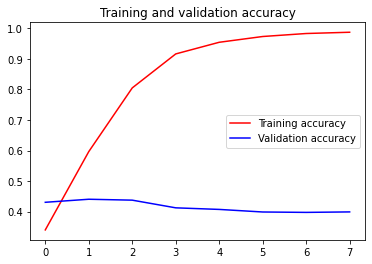

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

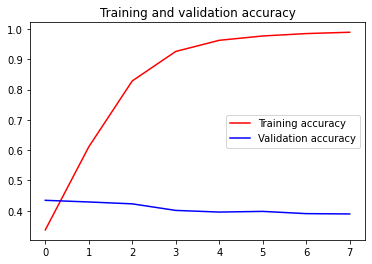

In [80]:
import matplotlib.pyplot as plt
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

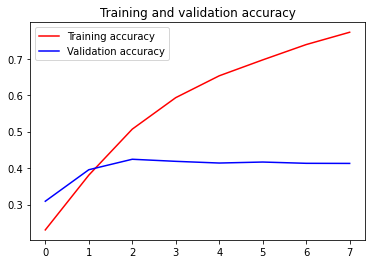

In [81]:
import matplotlib.pyplot as plt
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

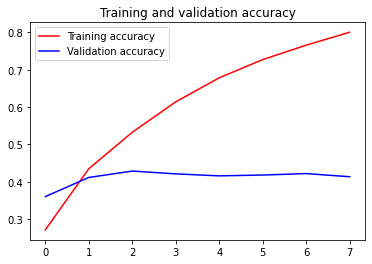

In [82]:
import matplotlib.pyplot as plt
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

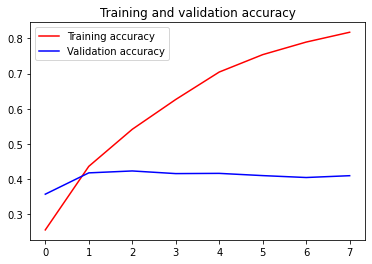

In [83]:
import matplotlib.pyplot as plt
acc = history_5.history['accuracy']
val_acc = history_5.history['val_accuracy']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

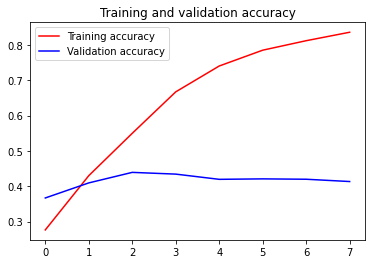

In [84]:
import matplotlib.pyplot as plt
acc = history_6.history['accuracy']
val_acc = history_6.history['val_accuracy']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

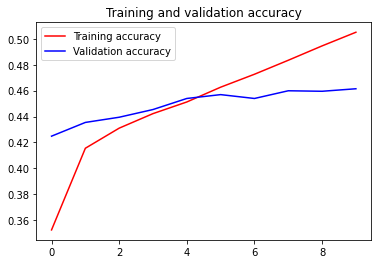

In [85]:
import matplotlib.pyplot as plt
acc = history_7.history['accuracy']
val_acc = history_7.history['val_accuracy']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()